# Image Preparation
1. Transform images into an array
   
2. Apply cosine similarity to look for similar products
   
3. Improve similarity calculation by scaling and using image embedding

## IMPORT LIBRARIES

In [1]:
import os
import numpy as np
import pandas as pd
import math
from natsort import natsorted
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from PIL import Image

from keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.metrics.pairwise import cosine_similarity

## LOAD DATA

In [2]:
all = pd.read_csv(r'./../data/cleaned_data/filtered_all4.csv')

In [3]:
all.head()

link   
0  /en/product/denize-bubble-crepe-dress-sand-bel...  \
1  /en/product/cabane-printed-shirt-blue-hartford...   
2  /en/product/garden-striped-cotton-poplin-top-b...   
3  /en/product/tsikis-x-alma-deia-exclusive-blava...   
4  /en/product/peggy-ibiza-striped-dress-yellow-t...   

                                                 img   
0  https://static.smallable.com/1686202-648x648q8...  \
1  https://static.smallable.com/1588974-648x648q8...   
2  https://static.smallable.com/1677878-648x648q8...   
3  https://static.smallable.com/1641315-648x648q8...   
4  https://static.smallable.com/1669582-648x648q8...   

                                           product   color              brand   
0                        denize bubble crepe dress    sand         bellepiece  \
1                             cabane printed shirt    blue           hartford   
2                 garden striped cotton poplin top    blue      girls of dust   
3  tsikis x alma deia exclusive - blava body chain  orange          alma deia   
4                        peggy ibiza striped dress  yellow  the label edition   

   greenable  discounted  disc_price  orig_price collection      label gender   
0          0           1       139.3       199.0         ss      dress      w  \
1          0           0       155.0       155.0         ss        top      w   
2          0           1       108.0       135.0         ss        top      w   
3          0           0       215.0       215.0         ss  underwear      w   
4          0           1       308.0       440.0         ss      dress      w   

       product_category        category  
0          long dresses  dress_overalls  
1    long sleeve shirts             top  
2  short sleeve blouses             top  
3             necklaces         jewelry  
4          long dresses  dress_overalls

## FUNCTIONS TO GET SIMILAR PRODUCTS FOR PRODUCT RECOMMENDATION

In [4]:
def get_similar_products(product_index, similarity_matrix, num_similar=5):
    """This function will get the top 5 similar products regardless of the categories they belong to"""
    # Get the similarity scores of the given product with all other products
    product_scores = similarity_matrix[product_index]
    
    # Sort the product scores in descending order
    sorted_indices = np.argsort(product_scores)[::-1]
    sorted_scores = product_scores[sorted_indices]
    
    # Retrieve the top similar products and their scores
    similar_products = sorted_indices[1:num_similar+1]
    similar_scores = np.round(sorted_scores[1:num_similar+1],3)
    
    return similar_products, similar_scores

In [5]:
def show_product_chosen(product_index): 
    """Function to show the image of the product used to look for similarities"""
    plt.figure()
    plt.title(class_labels[labels[product_index]])
    plt.imshow(images_normalized[product_index])
    plt.axis(False)
    plt.tight_layout()
    plt.show()

In [6]:
def get_similar_products_per_category(product_index, similarity_matrix, num_similar=8):
    """This function will get similar products that belong in the categories other than the one chosen"""
    
    # Get the similarity scores of the given product with all other products
    product_scores = similarity_matrix[product_index]
    
    # Sort the product scores in descending order
    sorted_indices = np.argsort(product_scores)[::-1]
    sorted_scores = product_scores[sorted_indices]
    
    # Dictionary to store selected products per category
    selected_products = {}
    
    # Retrieve the top similar products from different categories
    similar_products = []
    product_category = labels[product_index]
    
    for index in sorted_indices:
        category = labels[index]
        if category != product_category and category not in selected_products:
            similar_products.append(index)
            selected_products[category] = index
        if len(similar_products) >= num_similar:
            break
    
    similar_scores = np.round(sorted_scores[1:num_similar+1],3)
    
    return similar_products, similar_scores

In [7]:
# Function to visualize the distribution, mean and median of each continuous variable.
def show_similar_products(similar_products, product_score):
    a = math.ceil(len(similar_products)/3)  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (14, a*5))
    plt.suptitle("Similar Products", fontsize = 15, y=1)
    plt.grid(False)

    for s, p in zip(similar_products, product_score): 
        plt.subplot(a, b, c)
        fig = plt.imshow(images_normalized[s])
        plt.title(class_labels[labels[s]])
        plt.xlabel(f"Similarity : {p:.3f}")
        c = c + 1

    plt.tight_layout()
    plt.show()

## PREPARE LABELS LIST

> **The labels expected are:**
> 
> | category     |label|
> |----------------|-----|
> | accessories    | 0 |
> | bag            | 1 |
> | bottom         | 2 |
> | coat           | 3 |
> | dress_overalls | 4 |
> | jewelry        | 5 |
> | jumper         | 6 |
> | top            | 7 |

In [8]:
# unique values in the category column, arranged in alphabetical order
class_labels = sorted(list(all.category.unique()))

In [9]:
# check list
class_labels

['accessories',
 'bag',
 'bottom',
 'coat',
 'dress_overalls',
 'jewelry',
 'jumper',
 'top']

In [10]:
len(class_labels) # number of categories

8

In [11]:
# creating a list with encoded labels  
labels = all.category.apply(lambda x: 0 if x == 'accessories' else (
                                1 if x == 'bag' else (
                                    2 if x == 'bottom' else (
                                        3 if x == 'coat' else (
                                            4 if x == 'dress_overalls' else (
                                                5 if x == 'jewelry' else (
                                                    6 if x == 'jumper' else 7
                                                    )))))))

In [12]:
labels.value_counts()

category
7    1447
2     983
0     764
4     643
6     601
1     548
5     547
3     345
Name: count, dtype: int64

In [13]:
# save labels to csv for future use
labels.to_csv('labels.csv', index=False)

## PREPARE RAW IMAGE ARRAY

In [14]:
# image directory path
image_directory = "/Users/rachelleflores/Documents/GitHub/fashion_product_recommender/data/images/" 

In [15]:
# Create empty lists to store the image data and corresponding labels
images = []

# Get a sorted list of image file names in the directory
# Previously got results where the files loaded did not follow the same order as the dataframe
image_file_names = natsorted(os.listdir(image_directory))

# Iterate through each image in the folder
for image_name in image_file_names:
    image_path = os.path.join(image_directory, image_name)
    image = load_img(image_path, target_size=(224, 224))  # Resize the images to a fixed size required for VGG16 for later embedding
    image = img_to_array(image)
    images.append(image)

In [16]:
# Convert the image and label lists to numpy arrays
images_array = np.array(images)
labels_array = np.array(labels)

In [17]:
# Normalize the pixel values to a range of 0-1
images_normalized = images_array.astype('float32') / 255.0

In [18]:
# save to file
#np.save('images.npy', images_normalized)

In [19]:
# create 2D image matrix
images_matrix = np.array([image.flatten() for image in images_normalized])

In [20]:
images_matrix.shape

(5878, 150528)

## COSINE SIMILARITY

In [21]:
# create similarity matrix using cosine similarity
similarity_matrix = cosine_similarity(images_matrix)

In [22]:
similarity_matrix

array([[1.0000196 , 0.9699422 , 0.9795449 , ..., 0.8435614 , 0.81602377,
        0.9184724 ],
       [0.9699422 , 0.9999952 , 0.96918213, ..., 0.8529568 , 0.85771245,
        0.9413284 ],
       [0.9795449 , 0.96918213, 1.0000052 , ..., 0.8443718 , 0.84450454,
        0.9271786 ],
       ...,
       [0.8435614 , 0.8529568 , 0.8443718 , ..., 1.0000004 , 0.8524807 ,
        0.8533082 ],
       [0.81602377, 0.85771245, 0.84450454, ..., 0.8524807 , 1.0000446 ,
        0.9066502 ],
       [0.9184724 , 0.9413284 , 0.9271786 , ..., 0.8533082 , 0.9066502 ,
        1.0000015 ]], dtype=float32)

In [23]:
similarity_matrix.shape

(5878, 5878)

### RECOMMENDER USING RAW IMAGE ARRAY

In [24]:
# Trying out the functions to get similar products
product_index = 3892
similar_products, similar_scores = get_similar_products(product_index, similarity_matrix)

# Print the indices of similar products
print("Similar products for product at index", product_index)
print(similar_products, similar_scores)

Similar products for product at index 3892
[3888 5415 5513 5257 5242] [0.978 0.975 0.972 0.97  0.967]


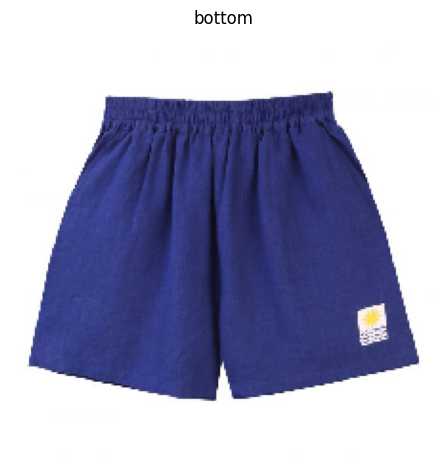

In [25]:
show_product_chosen(product_index)

/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_35526/759514152.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


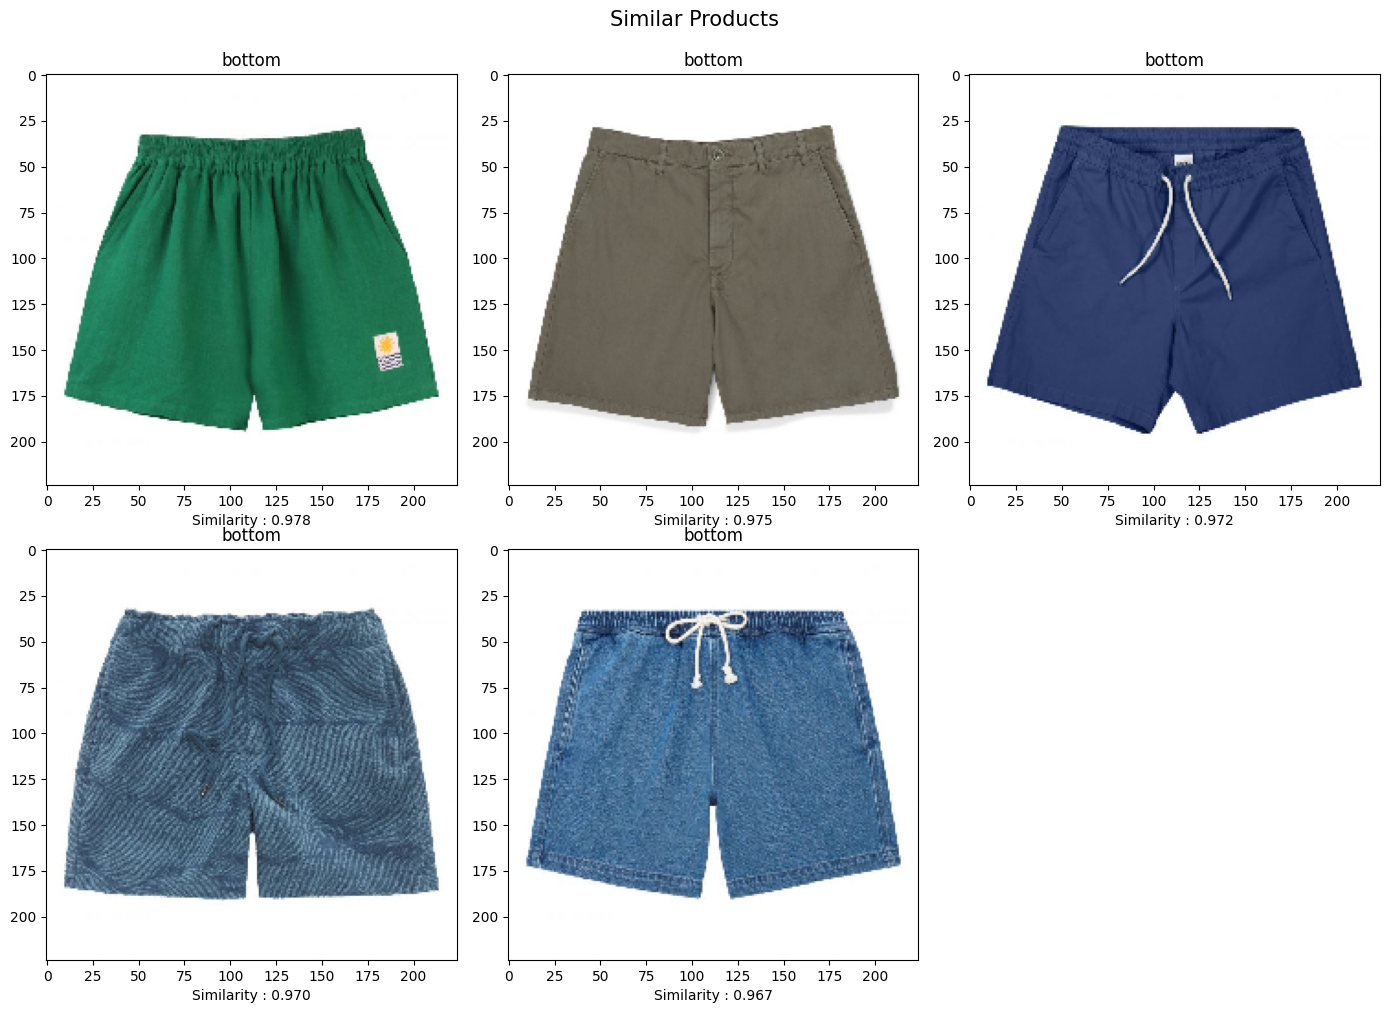

In [26]:
show_similar_products(similar_products, similar_scores) # results look promising as it was able to find similar products in the same category

In [27]:
# # Trying out the functions to get complementary products
similar_products_cat, product_scores_cat = get_similar_products_per_category(product_index, similarity_matrix, num_similar=8)

# Print the indices of similar products
print("Similar products for product at index", product_index)
print(similar_products_cat, product_scores_cat)

Similar products for product at index 3892
[4082, 5092, 5127, 1228, 1272, 3921, 3169] [0.978 0.975 0.972 0.97  0.967 0.965 0.965 0.964]


/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_35526/759514152.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


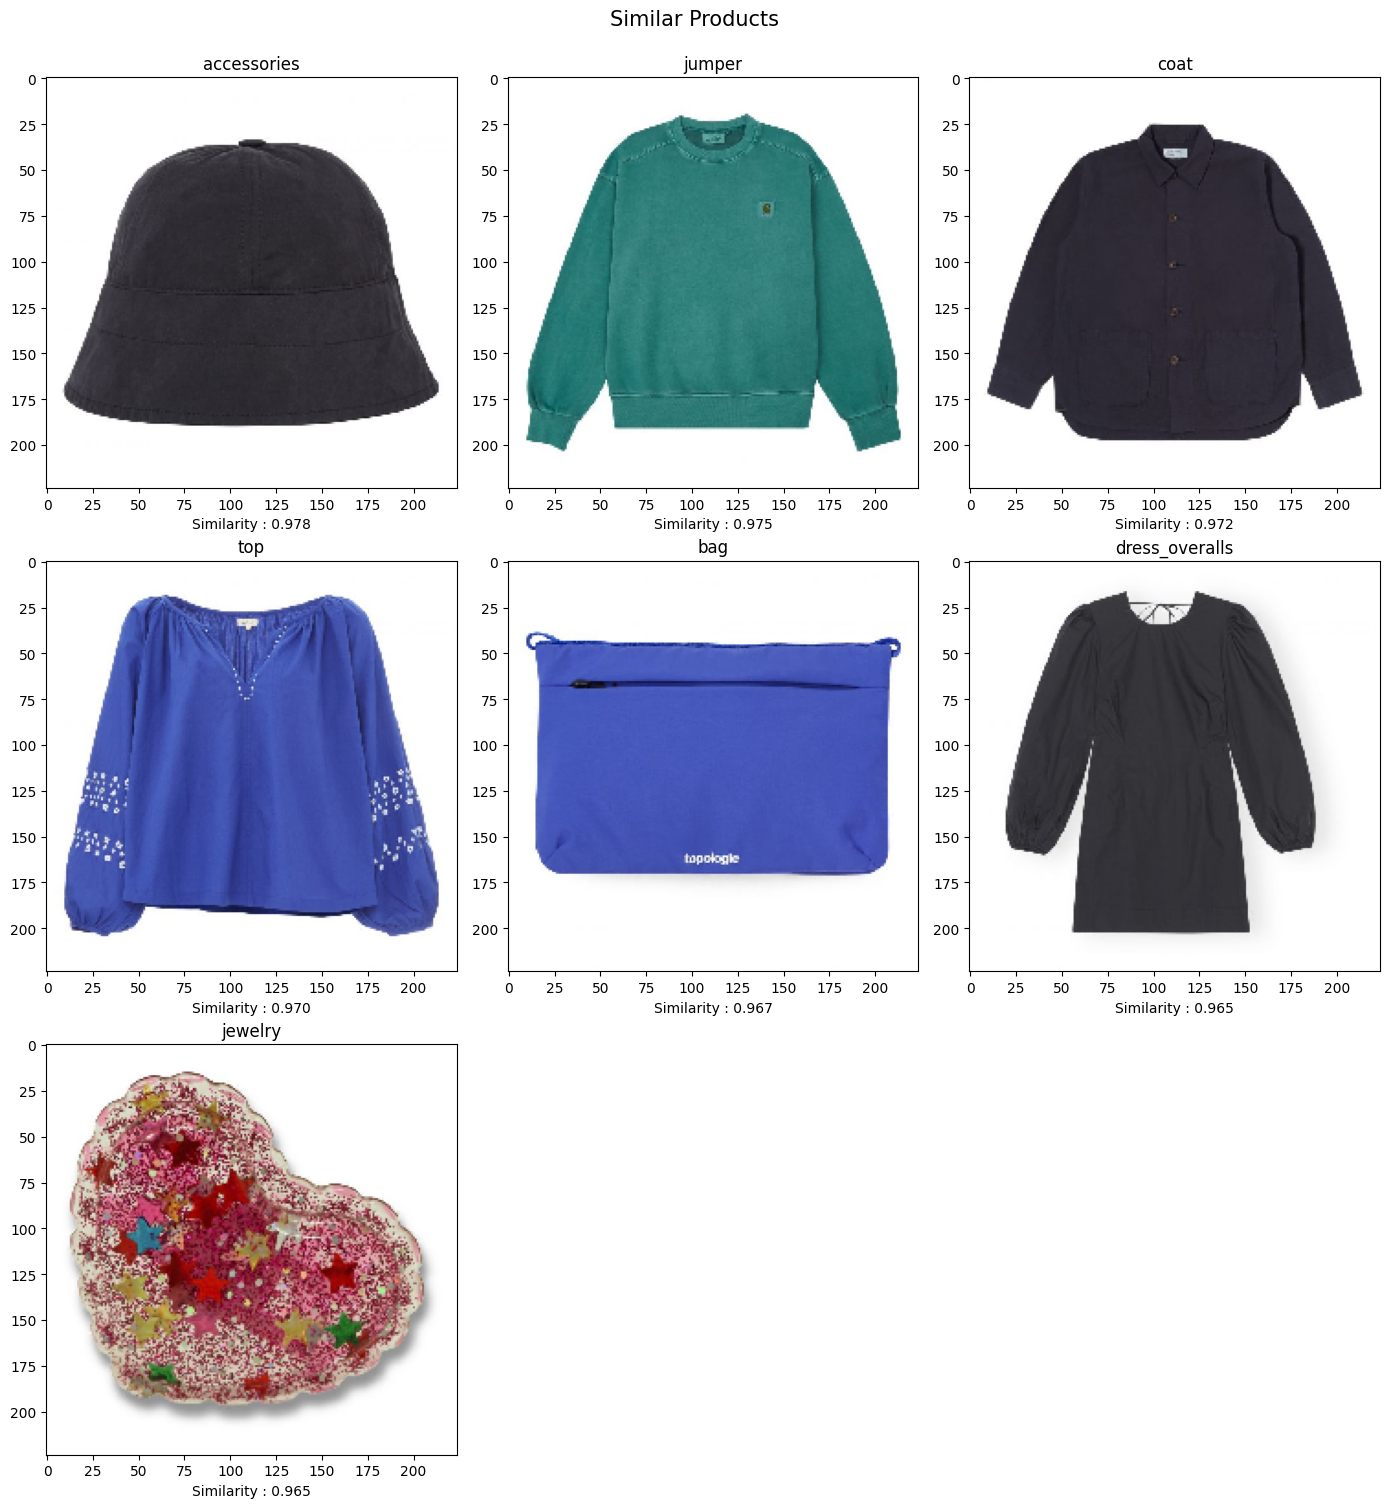

In [28]:
show_similar_products(similar_products_cat, product_scores_cat)

## SCALED MATRIX

> Standardization scales the features to have zero mean and unit variance, which can help improve the similarity calculation by eliminating the influence of different scales in the image arrays.
> 
> By incorporating this step, we can enhance the accuracy of the similarity calculation and obtain better results from the recommender system.

In [29]:
# Standardize the image data for improved similarity calculation
scaler = StandardScaler()
standardized_images = scaler.fit_transform(images_matrix)

In [30]:
# Calculate the cosine similarity between each pair of standardized images
similarity_matrix_scaled = cosine_similarity(standardized_images)

### RECOMMENDER

In [31]:
# Similar Products
similar_products_scaled, scaled_product_scores = get_similar_products(product_index, similarity_matrix_scaled)

# Print the indices of similar products
print("Similar products for product at index", product_index)
print(similar_products_scaled, scaled_product_scores)

Similar products for product at index 3892
[3888 5415 5127 5513 3108] [0.857 0.818 0.808 0.801 0.799]


/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_35526/759514152.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


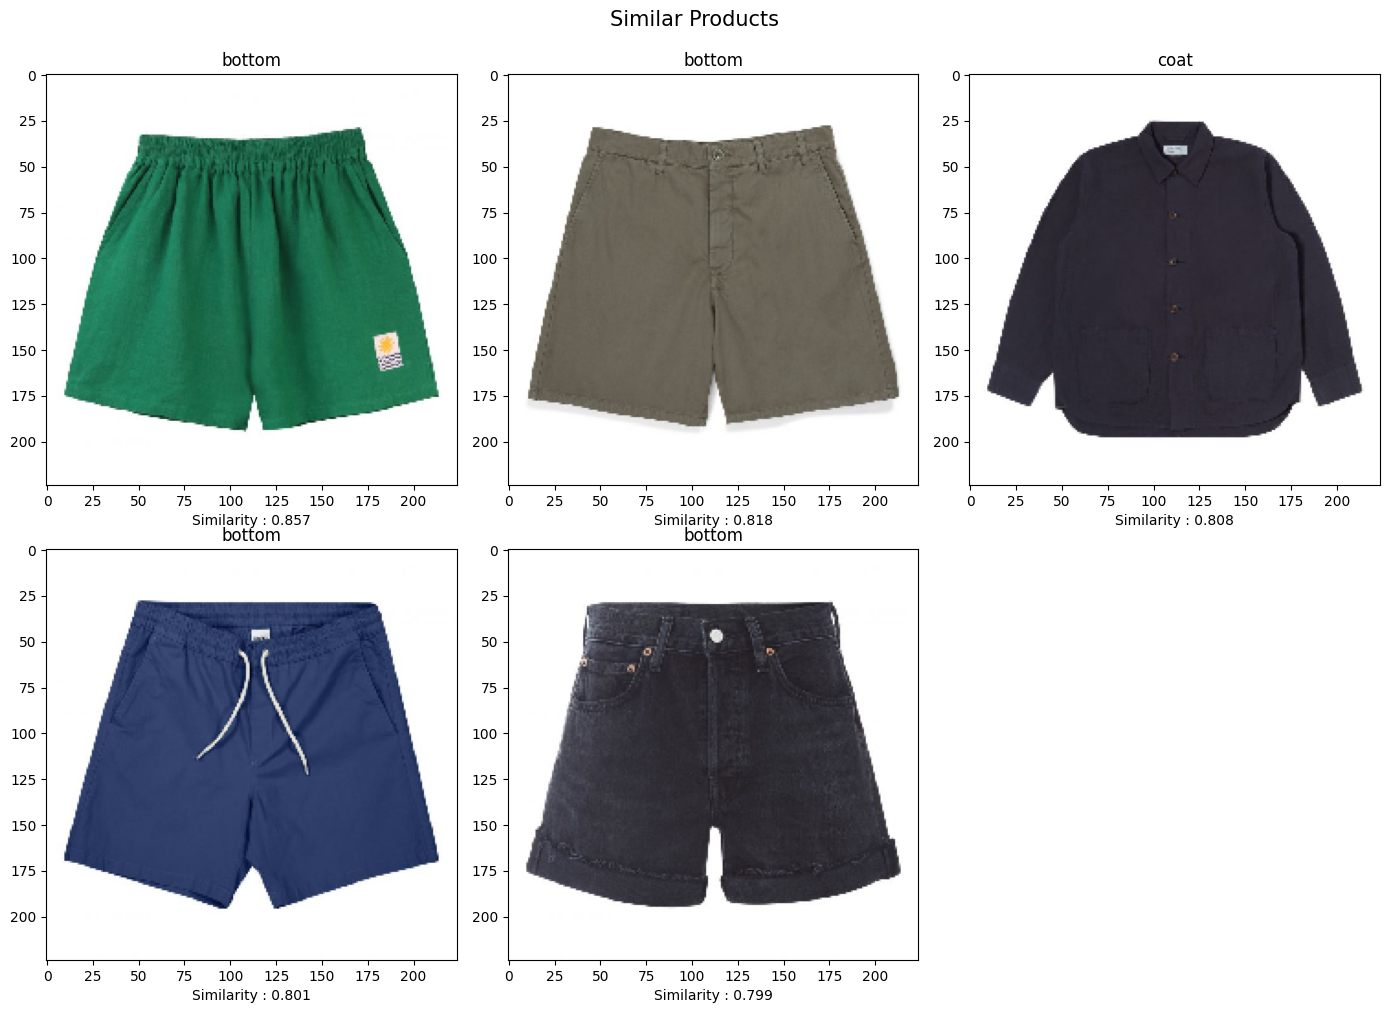

In [32]:
show_similar_products(similar_products_scaled, scaled_product_scores) 
# interesting... the scaled matrix included a jacket in the mix and not only shorts like in the previous result

In [33]:
# # Complementary products
scaled_similar_products_cat, scaled_product_scores_cat = get_similar_products_per_category(product_index, similarity_matrix_scaled, num_similar=8)

# Print the indices of similar products
print("Similar products for product at index", product_index)
print(scaled_similar_products_cat, scaled_product_scores_cat)

Similar products for product at index 3892
[5127, 4082, 5128, 4985, 3921, 150, 5465] [0.857 0.818 0.808 0.801 0.799 0.798 0.796 0.785]


/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_35526/759514152.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


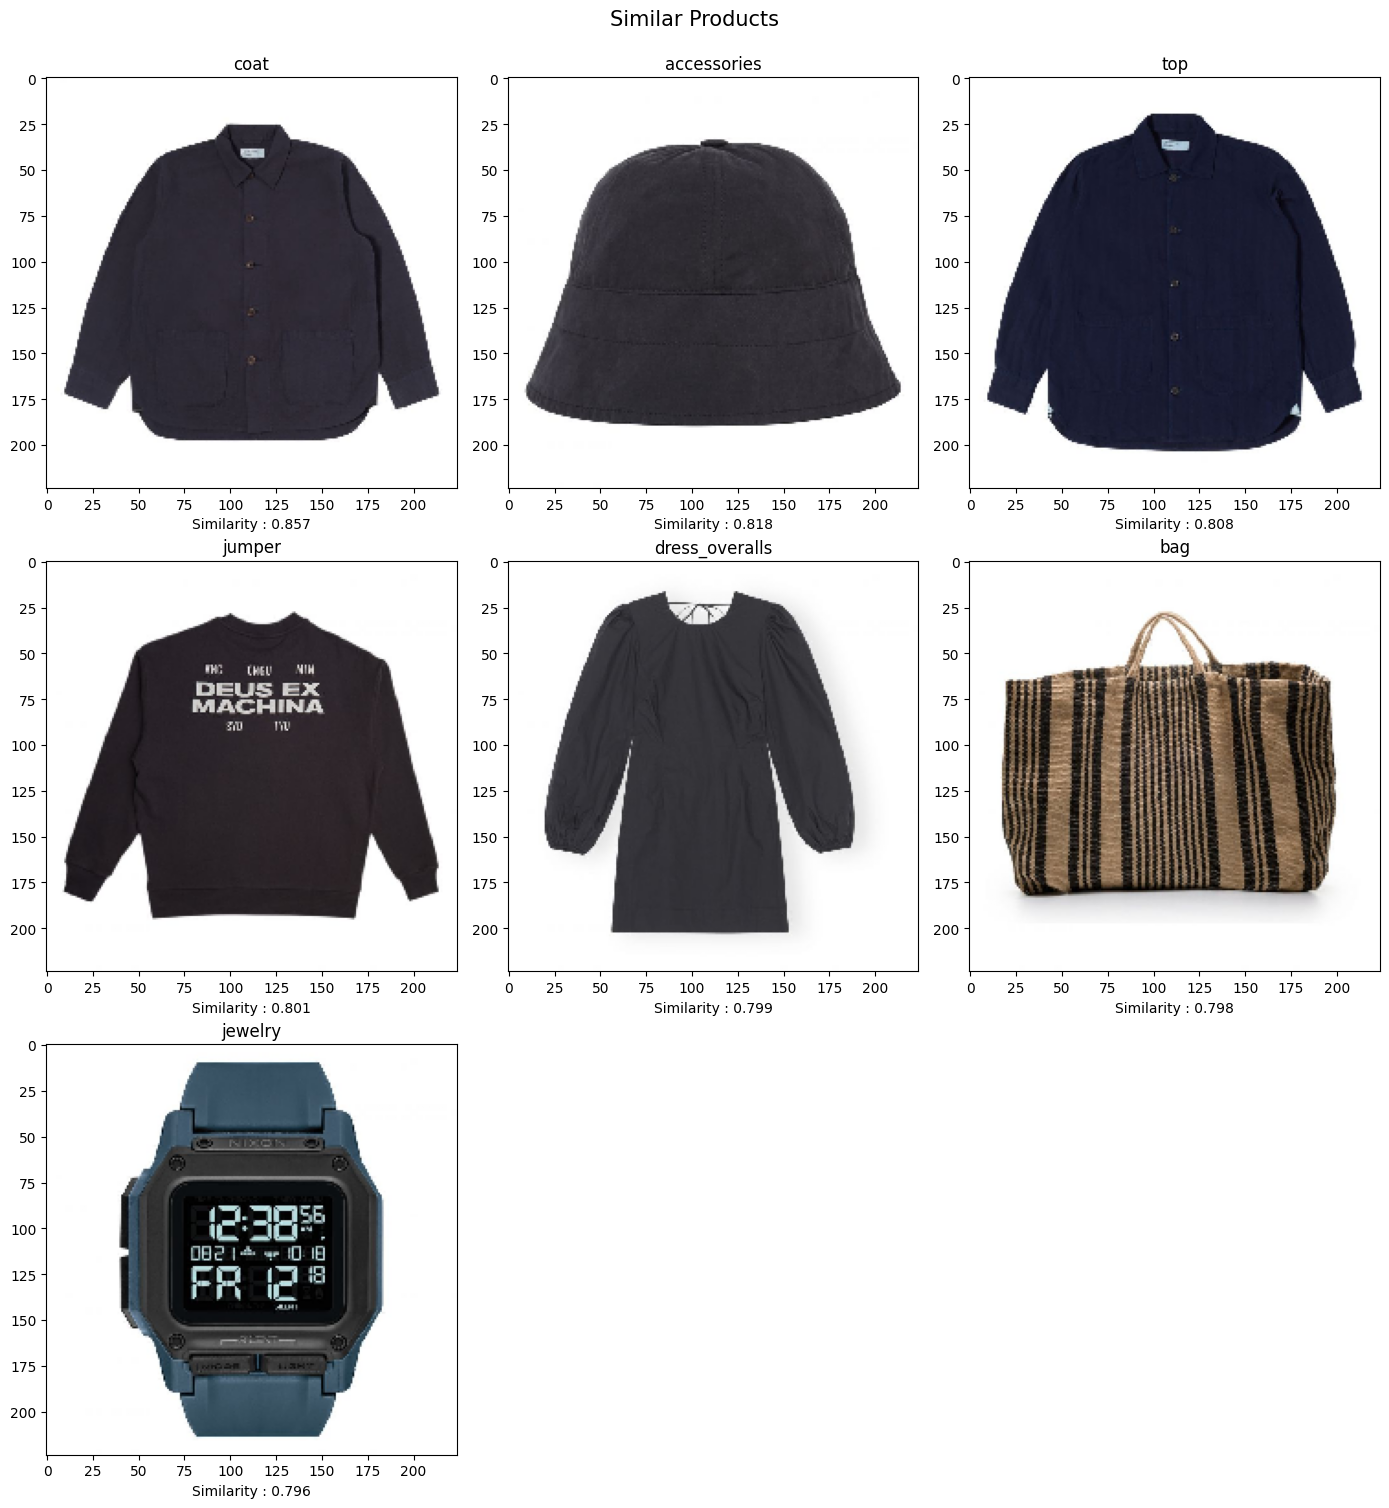

In [34]:
show_similar_products(scaled_similar_products_cat, scaled_product_scores_cat)

## IMAGE EMBEDDINGS

> To perform the analysis, we need to transform them into a more suitable representation — vectors of numbers named embeddings. 
> 
> Image embedding is a vector representation of an image in which images with similar motives have similar vector profiles.
> 
> We disregard the classification layer of the network and consider the penultimate layer instead and use that for the image’s vector-based 
> 
> representation.
>
> *https://towardsdatascience.com/image-analytics-for-everyone-image-embeddings-with-orange-7f0b91fa2ca2*

In [35]:
# Load the pretrained neural network VGG16 model with pre-trained weights (excluding the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False)

# Create an intermediate layer model to obtain embeddings from the fully connected layer
intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

> It takes an image as input and outputs the activations of the 'block5_pool' layer, which can be considered as a high-level representation
> 
> of the image after it has passed through several convolutional and pooling layers of VGG16. This new model can be used to generate image
> 
> embeddings, which are the feature representations used for various tasks like similarity calculations, clustering, or classification.

In [36]:
# Load the image using the appropriate filepath or URL
images_vgg16 = []

for filename in image_file_names:
    img = load_img(image_directory+filename, target_size=(224, 224))  # Resize the image to the input size required by the CNN
    img_array = img_to_array(img)  # Convert the image to an array
    img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension to represent the batch size (1 in this case)
    img_array = preprocess_input(img_array) # Preprocess the image according to VGG16 requirements
    images_vgg16.append(img_array)

In [37]:
images_vgg16_concat = np.concatenate(images_vgg16, axis=0)

In [38]:
images_vgg16_concat.shape

(5878, 224, 224, 3)

In [39]:
# Normalize the pixel values to a range of 0-1
images_vgg16_norm = images_vgg16_concat.astype('float32') / 255.0

In [40]:
# Generate the image embeddings by passing the image array through the intermediate layer model
embeddings_vgg16 = intermediate_layer_model.predict(images_vgg16_norm)

184/184 [==============================] - 2993s 16s/step


In [41]:
embeddings_vgg16.shape

(5878, 7, 7, 512)

In [42]:
embedded_matrix = np.array([image.flatten() for image in embeddings_vgg16])

In [43]:
embedded_matrix.shape

(5878, 25088)

### NONE-SCALED IMAGE EMBEDDINGS

In [44]:
embeddings_similarity_matrix = cosine_similarity(embedded_matrix)

In [45]:
# Assuming you want to find similar products for product at index 3892
product_index = 3892
e_similar_products, e_similar_scores = get_similar_products(product_index, embeddings_similarity_matrix)

# Print the indices of similar products
print("Similar products for product at index", product_index)
print(e_similar_products, e_similar_scores)

Similar products for product at index 3892
[3888  715 3889 5357 3674] [0.979 0.963 0.953 0.951 0.948]


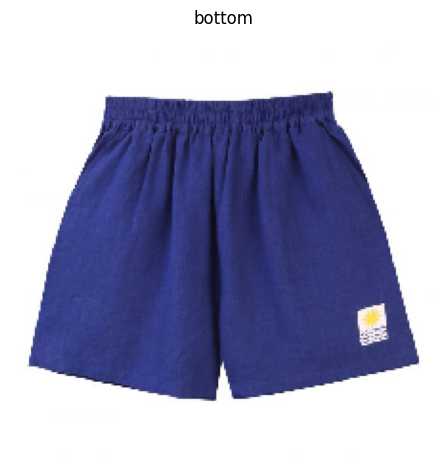

In [46]:
show_product_chosen(product_index)

/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_35526/759514152.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


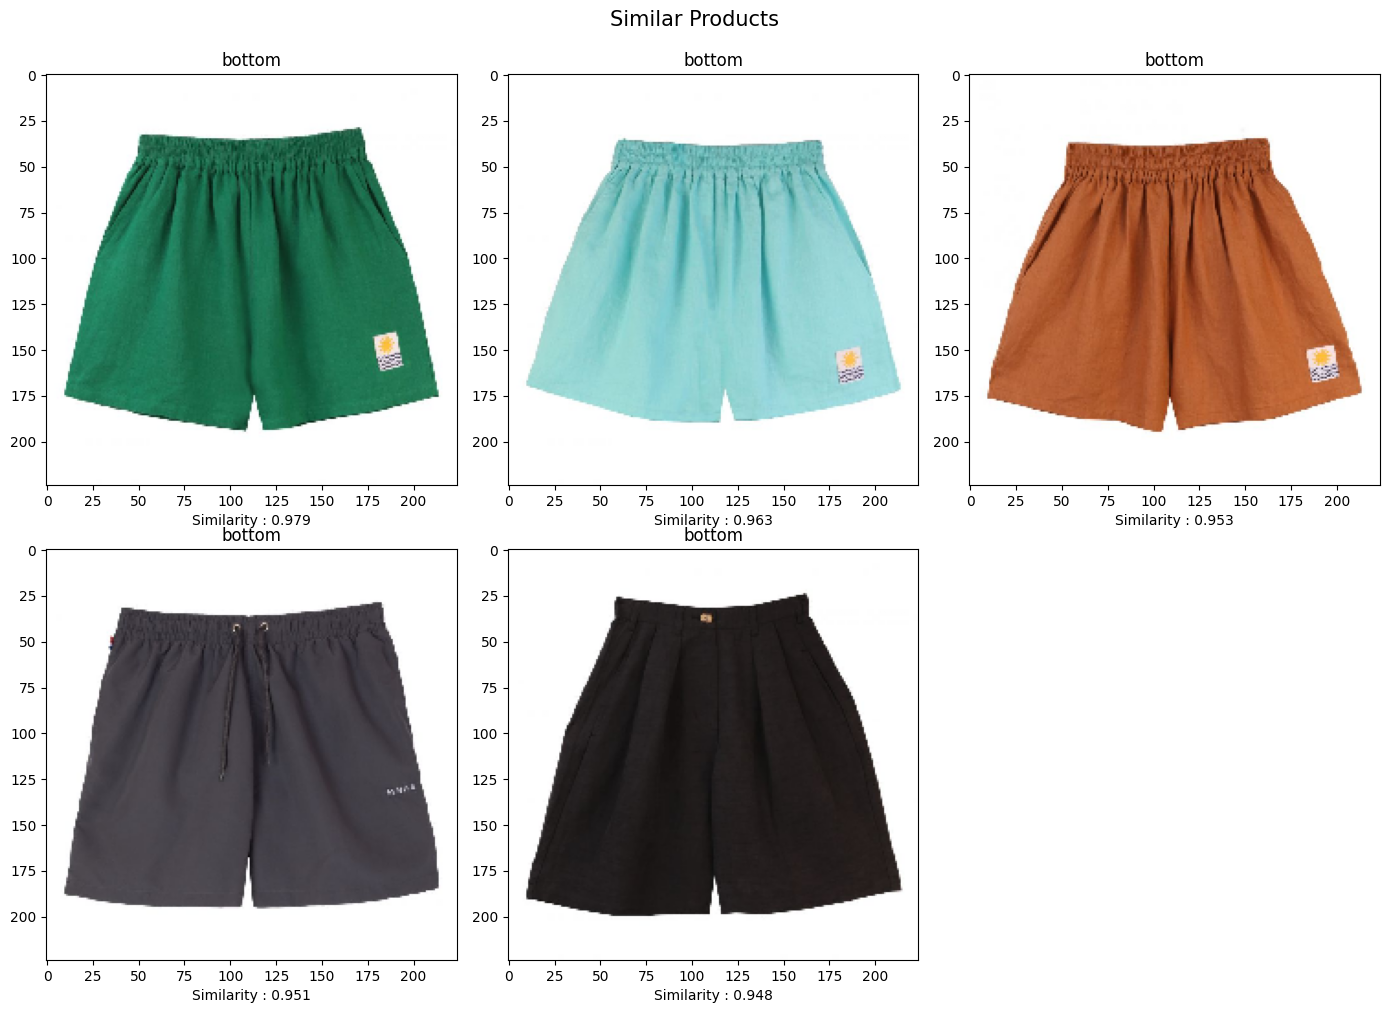

In [47]:
show_similar_products(e_similar_products, e_similar_scores)

In [48]:
# Assuming you want to find similar products for product at index
e_similar_products_cat, e_product_scores_cat = get_similar_products_per_category(product_index, embeddings_similarity_matrix, num_similar=6)

# Print the indices of similar products
print("Similar products for product at index", product_index)
print(e_similar_products_cat, e_product_scores_cat)


Similar products for product at index 3892
[2111, 2840, 5696, 3880, 2530, 206] [0.979 0.963 0.953 0.951 0.948 0.946]


In [49]:
all.iloc[203]

link                /en/product/fringe-organic-cotton-denim-shorts...
img                 https://static.smallable.com/1691381-648x648q8...
product                            fringe organic cotton denim shorts
color                                                           melon
brand                                                       alma deia
greenable                                                           0
discounted                                                          1
disc_price                                                       59.4
orig_price                                                       99.0
collection                                                         ss
label                                                          bottom
gender                                                              w
product_category                                               shorts
category                                                       bottom
Name: 203, dtype: ob

/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_35526/759514152.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


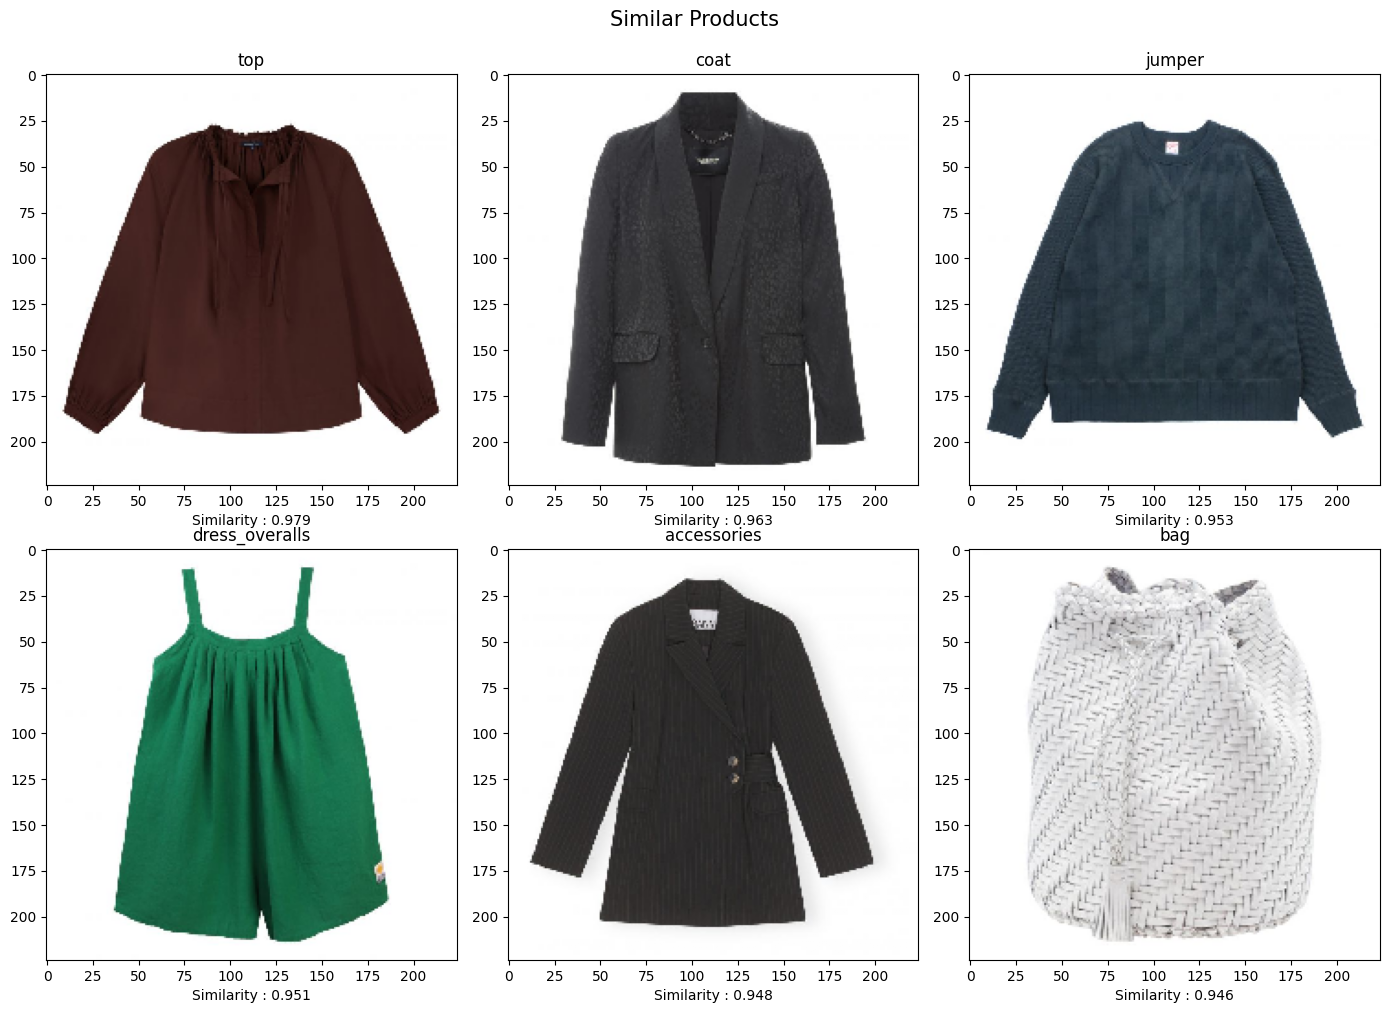

In [50]:
show_similar_products(e_similar_products_cat, e_product_scores_cat)

### SCALED EMBEDDINGS

In [51]:
scaled_embeddings = scaler.fit_transform(embedded_matrix)

In [52]:
scaled_embeddings.shape

(5878, 25088)

In [542]:
# save to file
np.save('scaled_embeddings.npy', scaled_embeddings)

In [54]:
scaled_embeddings_similarity_matrix = cosine_similarity(scaled_embeddings)

In [55]:
scaled_embeddings_similarity_matrix.shape

(5878, 5878)

In [56]:
# save to file
np.save('scaled_embeddings_similarity_matrix.npy', scaled_embeddings_similarity_matrix)

In [57]:
# product_indexes tried
# 3892 :  exactly same prods, other categories dynamic
# 244 : similar prod ok but other categories so-so
# 768 : exactly same prods, other categories ok
# 4568
# 5678

In [58]:
# Assuming you want to find similar products for product at index 0
se_similar_products, se_similar_scores = get_similar_products(product_index, scaled_embeddings_similarity_matrix)

# Print the indices of similar products
print("Similar products for product at index", product_index)
print(se_similar_products, se_similar_scores)

Similar products for product at index 3892
[3888 3889  715 5357 3674] [0.737 0.547 0.513 0.487 0.472]


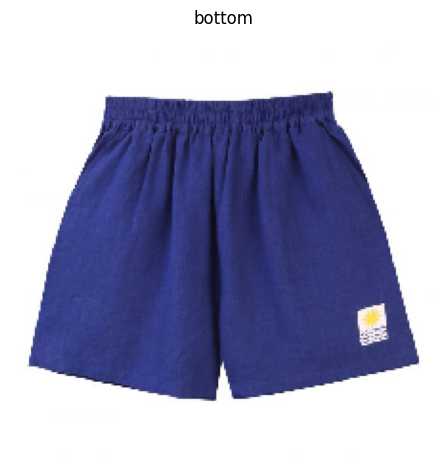

In [59]:
show_product_chosen(product_index)

/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_35526/759514152.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


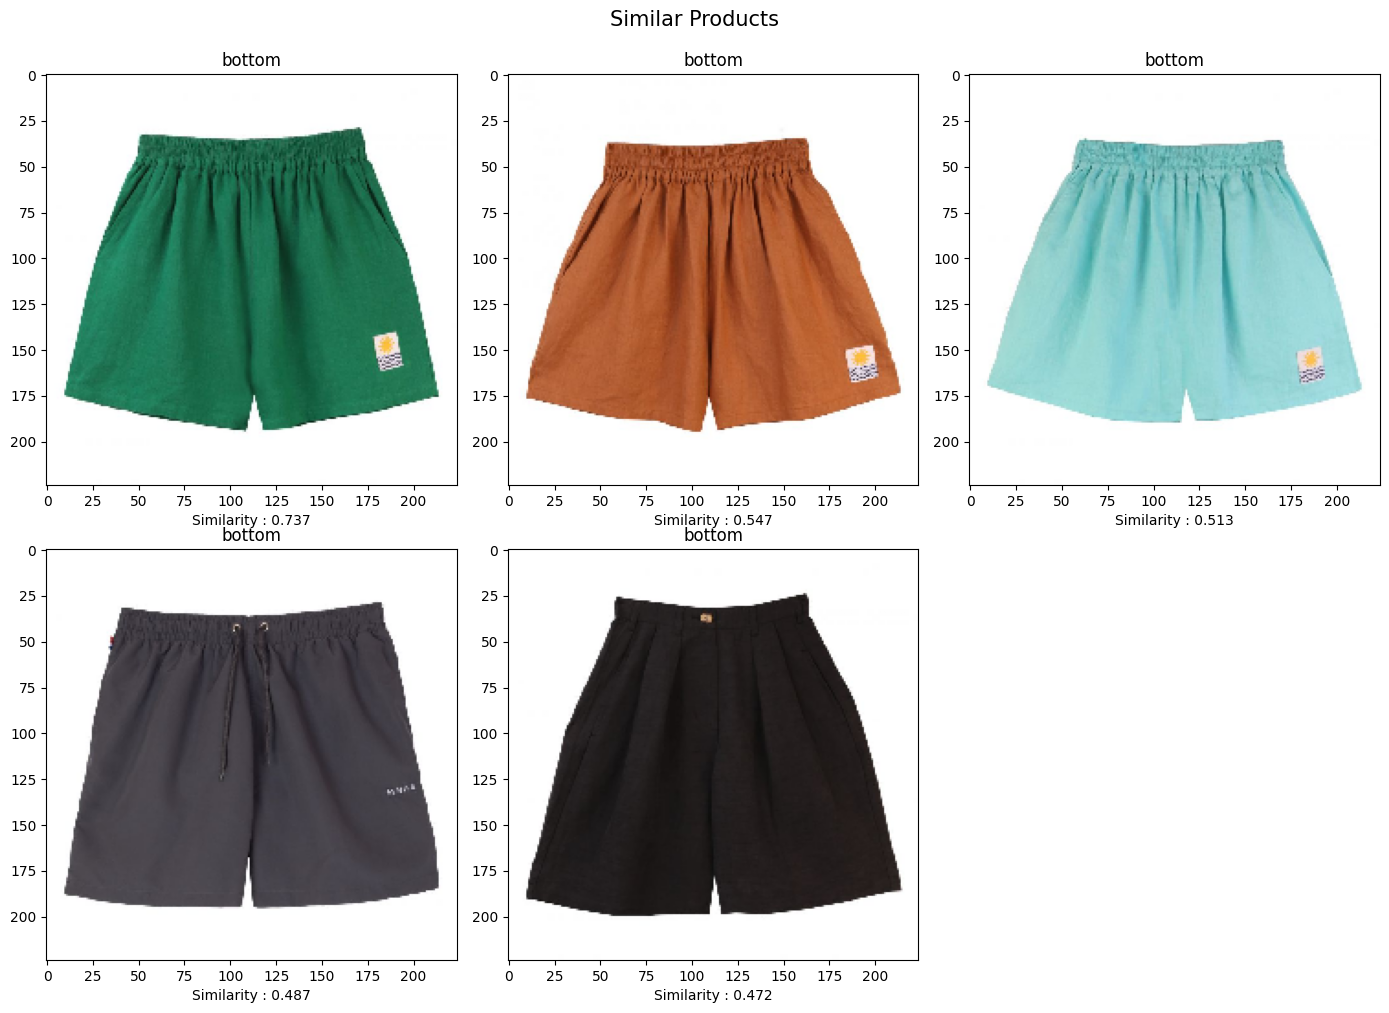

In [60]:
show_similar_products(se_similar_products, se_similar_scores) # same results as none-scaled embeddings

In [61]:
# Assuming you want to find similar products for product at index 0
se_similar_products_cat, se_product_scores_cat = get_similar_products_per_category(product_index, scaled_embeddings_similarity_matrix, num_similar=8)

# Print the indices of similar products
print("Similar products for product at index", product_index)
print(se_similar_products_cat, se_product_scores_cat )


Similar products for product at index 3892
[1565, 3880, 5369, 5865, 2530, 1272, 407] [0.737 0.547 0.513 0.487 0.472 0.451 0.442 0.434]


/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_35526/759514152.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(a, b, c)


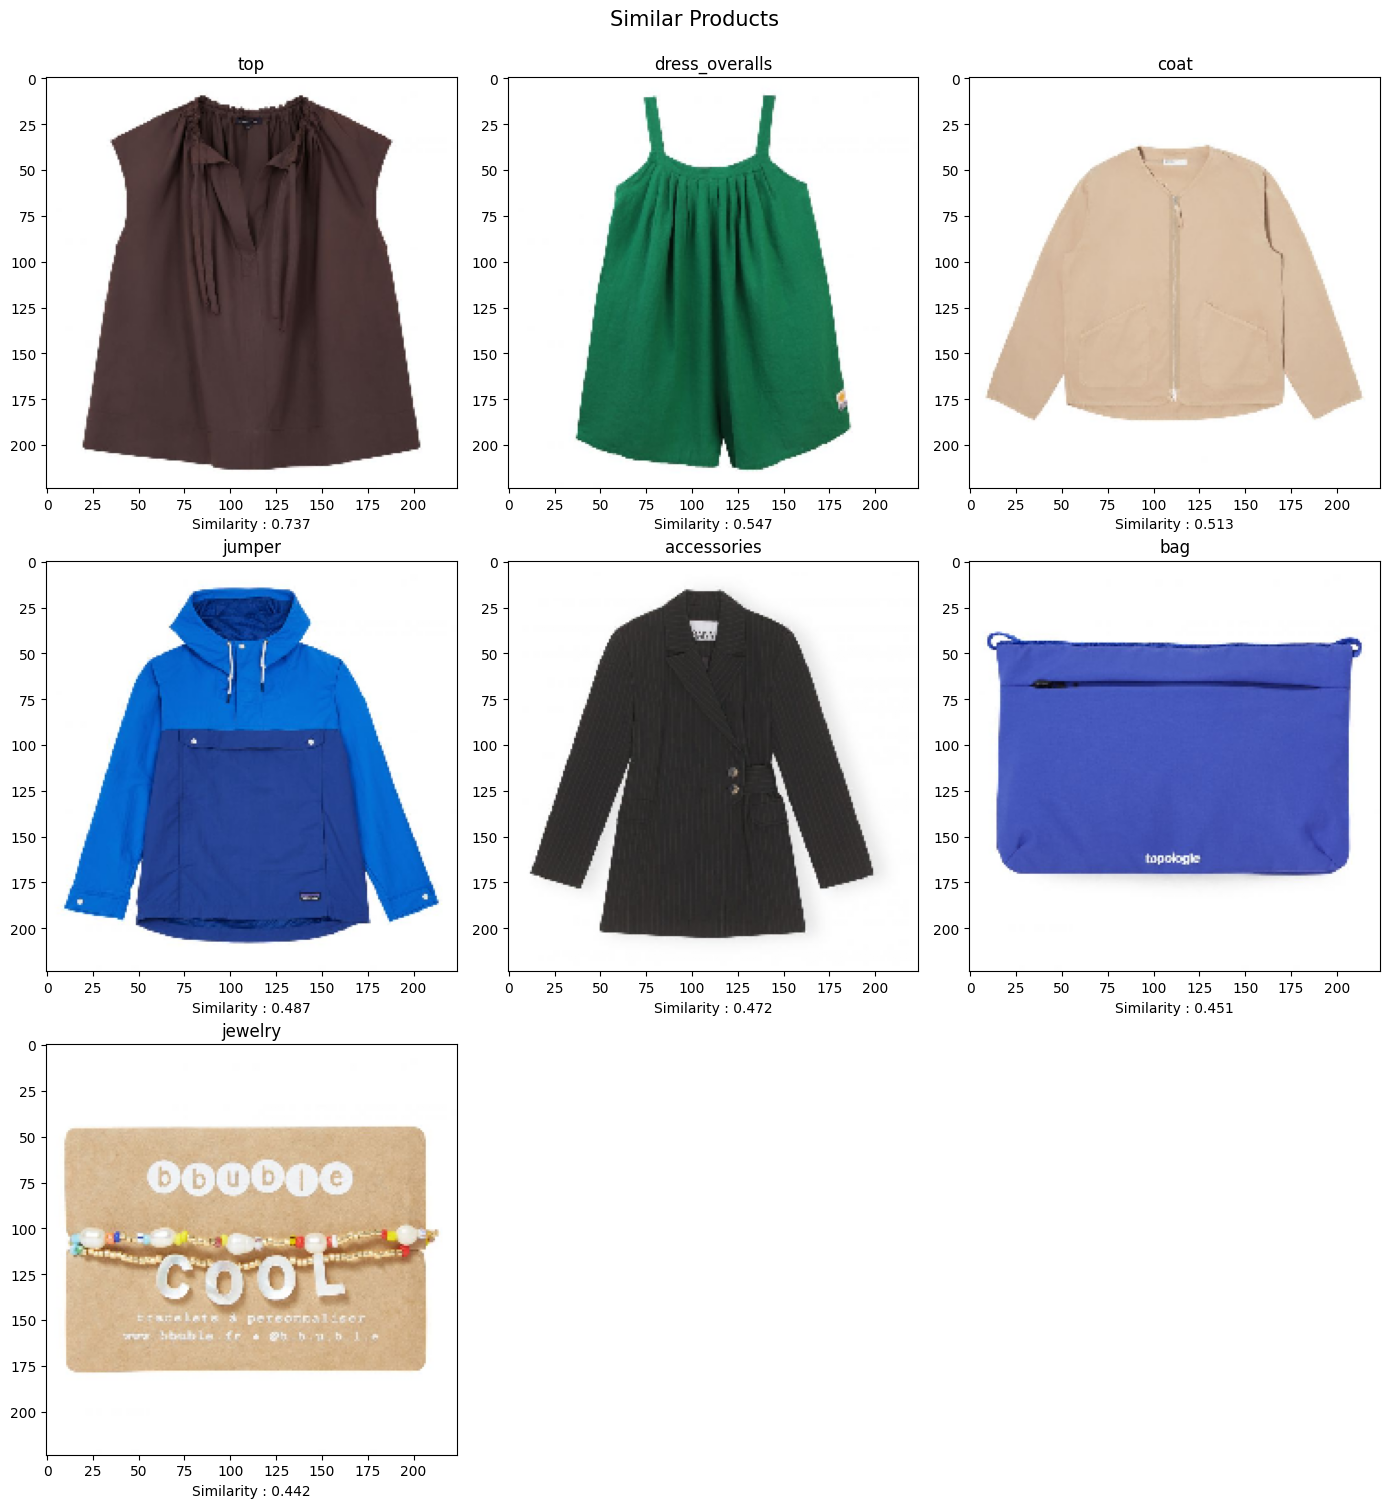

In [62]:
show_similar_products(se_similar_products_cat, se_product_scores_cat ) # gives more dynamic reccomendations